In [79]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from scipy.stats import kurtosis
from scipy.stats import skew
import scipy.stats as ss
from sklearn.metrics import *

In [80]:
# import merged dataset for Birds in four cities across different times with feature engineering 
data = pd.read_csv('final_merge.csv', index_col=0)

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10604 entries, 0 to 10603
Data columns (total 57 columns):
bar_count                  10604 non-null int64
battery_level              10604 non-null int64
bench_count                10604 non-null int64
bike_score                 10604 non-null float64
bus_count                  10604 non-null int64
city                       10604 non-null object
clds                       10604 non-null object
elevation                  10604 non-null float64
housing_units              10604 non-null float64
id                         10604 non-null object
land_area_in_sqmi          10593 non-null float64
latitude                   10604 non-null float64
longitude                  10604 non-null float64
nest_id                    10604 non-null object
park_count                 10604 non-null int64
parking_count              10604 non-null int64
point                      10604 non-null object
pop_density                10574 non-null float64
populati

# Additional Feature Engineering

In [82]:
# create log features for closest_highway, closest primary, closest residential, closest secondary and closest scooter
data['log_highway'] = np.log(data['closest_highway'])
data['log_scooter'] = np.log(data['closest_scooter'])
data['log_primary'] = np.log(data['closest_primary'])
data['log_residential'] = np.log(data['closest_residential'])
data['log_secondary'] = np.log(data['closest_secondary'])
data['walk_bike_dynamic'] = data['walk_score'] * data['bike_score']
data['walk_bike_add'] = data['walk_score'] + data['bike_score']

# Plotting Distributions

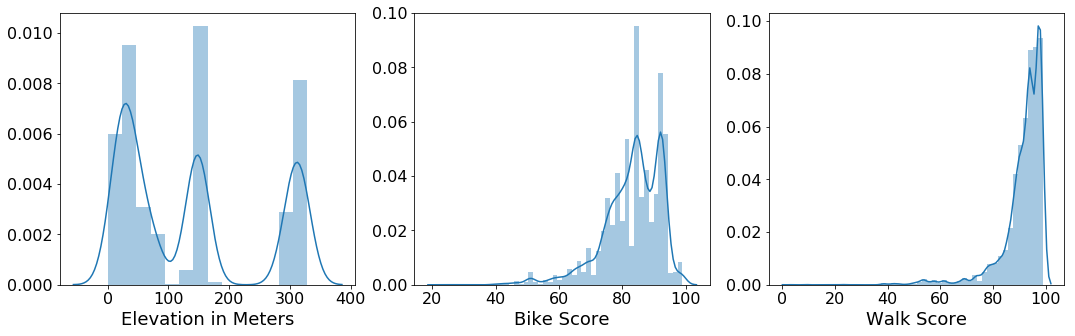

In [83]:
# Plot distributions
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 5))

sns.distplot(data['elevation'], ax=ax0); ax0.set_xlabel('Elevation in Meters', fontsize=18)
sns.distplot(data['bike_score'], ax=ax1); ax1.set_xlabel('Bike Score', fontsize=18)
sns.distplot(data['walk_score'], ax=ax2); ax2.set_xlabel('Walk Score', fontsize=18)



ax0.tick_params(labelsize=16); ax1.tick_params(labelsize=16); ax2.tick_params(labelsize=16);

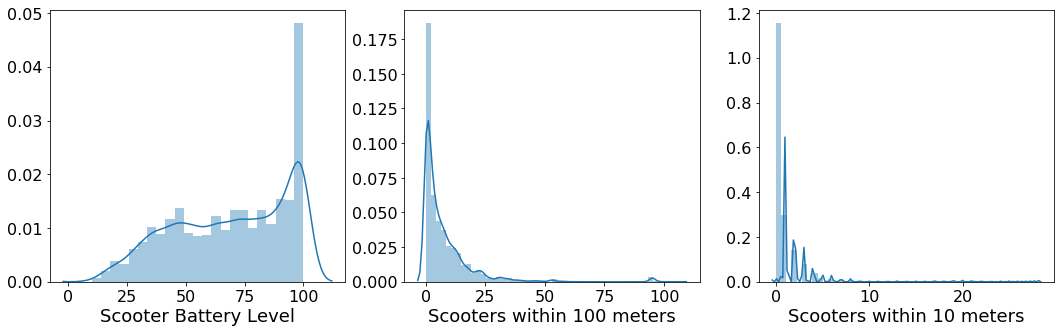

In [84]:
fig, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(18, 5))

sns.distplot(data['battery_level'], ax=ax3); ax3.set_xlabel('Scooter Battery Level', fontsize=18);
sns.distplot(data['hundred_meter'], ax=ax4); ax4.set_xlabel('Scooters within 100 meters', fontsize=18)
sns.distplot(data['ten_meter'], ax=ax5); ax5.set_xlabel('Scooters within 10 meters', fontsize=18)

ax3.tick_params(labelsize=16); ax4.tick_params(labelsize=16); ax5.tick_params(labelsize=16); 

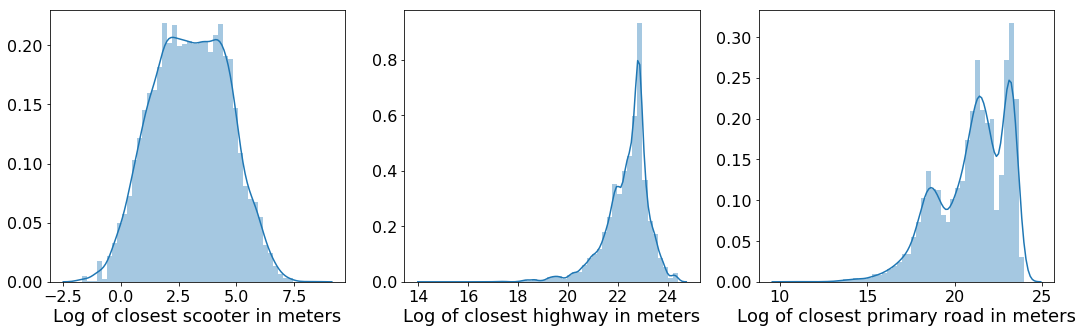

In [85]:
fig, (ax6, ax7, ax8) = plt.subplots(1, 3, figsize=(18, 5))

sns.distplot(data['log_scooter'], ax=ax6); ax6.set_xlabel('Log of closest scooter in meters', fontsize=18)
sns.distplot(data['log_highway'], ax=ax7); ax7.set_xlabel('Log of closest highway in meters', fontsize=18)
sns.distplot(data['log_primary'], ax=ax8); ax8.set_xlabel('Log of closest primary road in meters', fontsize=18)


ax6.tick_params(labelsize=16); ax7.tick_params(labelsize=16); ax8.tick_params(labelsize=16);

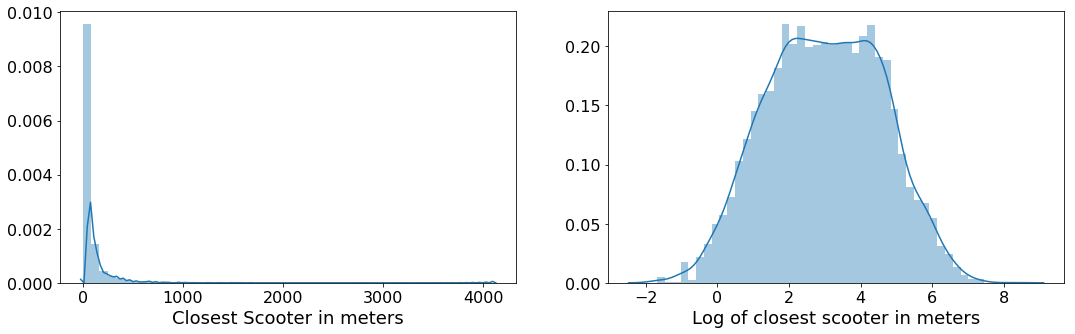

In [86]:
fig, (ax9, ax10) = plt.subplots(1, 2, figsize=(18, 5))

sns.distplot(data['closest_scooter'], ax=ax9); ax9.set_xlabel('Closest Scooter in meters', fontsize=18)
sns.distplot(data['log_scooter'], ax=ax10); ax10.set_xlabel('Log of closest scooter in meters', fontsize=18)


ax9.tick_params(labelsize=16); ax10.tick_params(labelsize=16); 

In [87]:
# check skew and kurtosis for Closest Scooter to check distribution stats
print('Closest Scooter Skew is', skew(data['closest_scooter']))
print('Closest Scooter Kurtosis is', kurtosis(data['closest_scooter']))

Closest Scooter Skew is 8.68072910975983
Closest Scooter Kurtosis is 175.42706171598118


In [88]:
# check skew and kurtosis for Log scooter to check distribution stats
print('Log Scooter Skew is', skew(data['log_scooter']))
print('Log Scooter Kurtosis is', kurtosis(data['log_scooter']))

Log Scooter Skew is -0.03209639902735151
Log Scooter Kurtosis is -0.5853567675607976


In [89]:
print(np.mean(data['closest_highway']))
print(np.median(data['closest_highway']))

7009078310.345264
6433532493.201509


# Statistical Analysis

In [90]:
# write t_test function
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   

In [91]:
data.groupby('nest_dummy')['bike_score'].mean()

nest_dummy
0    83.168605
1    82.786431
Name: bike_score, dtype: float64

In [92]:
# create stratified bike scores by nest_dummy
nest = data['bike_score'][data['nest_dummy'] == 1]
no_nest = data['bike_score'][data['nest_dummy'] == 0]

In [93]:
test = t_test(nest, no_nest, 0.05)
test 

DegFreedom    3325.950479
Difference      -0.382174
Statistic       -1.755682
PValue           0.079235
Low95CI         -0.808972
High95CI         0.044623
dtype: float64

The PValue is greater than the 5% significance level and the 95% Confidence interval straddles 0 so we cannot reject the null hypothesis. This means there is a high chance that the difference in means is from random variation alone.

In [94]:
data.groupby('nest_dummy')['walk_score'].mean()

nest_dummy
0    91.206909
1    92.601051
Name: walk_score, dtype: float64

In [95]:
# create stratified walk scores by nest_dummy
nest = data['walk_score'][data['nest_dummy'] == 1]
no_nest = data['walk_score'][data['nest_dummy'] == 0]

In [96]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    4.257916e+03
Difference    1.394142e+00
Statistic     8.165327e+00
PValue        4.182608e-16
Low95CI       1.059404e+00
High95CI      1.728880e+00
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of walk score by nest classification.

In [97]:
data.groupby('nest_dummy')['battery_level'].mean()

nest_dummy
0    62.900364
1    94.888199
Name: battery_level, dtype: float64

In [98]:
# create stratified battery level by nest_dummy
nest = data['battery_level'][data['nest_dummy'] == 1]
no_nest = data['battery_level'][data['nest_dummy'] == 0]

In [99]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    7941.339627
Difference      31.987835
Statistic       98.086971
PValue           0.000000
Low95CI         31.348559
High95CI        32.627110
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of battery levels by nest classification.

In [100]:
data.groupby('nest_dummy')['log_scooter'].mean()

nest_dummy
0    3.281436
1    1.891617
Name: log_scooter, dtype: float64

In [101]:
# create stratified log of closest scooter in meters by nest_dummy
nest = data['log_scooter'][data['nest_dummy'] == 1]
no_nest = data['log_scooter'][data['nest_dummy'] == 0]

In [102]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom     3.420579e+03
Difference    -1.389818e+00
Statistic     -3.966912e+01
PValue        1.856563e-283
Low95CI       -1.458511e+00
High95CI      -1.321126e+00
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of log of closest scooter in meters by nest classification.

In [103]:
data.groupby('nest_dummy')['ten_meter'].mean()

nest_dummy
0    0.764305
1    1.751075
Name: ten_meter, dtype: float64

In [104]:
# create stratified scooters within 10 meters by nest_dummy
nest = data['ten_meter'][data['nest_dummy'] == 1]
no_nest = data['ten_meter'][data['nest_dummy'] == 0]

In [105]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    3.399688e+03
Difference    9.867700e-01
Statistic     1.715737e+01
PValue        2.391500e-63
Low95CI       8.740067e-01
High95CI      1.099533e+00
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of scooter count within 10 meters by nest classification

In [106]:
data.groupby('nest_dummy')['elevation'].mean()

nest_dummy
0    128.608504
1    166.415091
Name: elevation, dtype: float64

In [107]:
# create stratified elevation in meters by nest_dummy
nest = data['elevation'][data['nest_dummy'] == 1]
no_nest = data['elevation'][data['nest_dummy'] == 0]

In [108]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    2.933097e+03
Difference    3.780659e+01
Statistic     1.262410e+01
PValue        1.290138e-35
Low95CI       3.193448e+01
High95CI      4.367870e+01
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of scooter elevation in meters by nest classification

In [109]:
data.groupby('nest_dummy')['log_highway'].mean()

nest_dummy
0    22.377643
1    22.361718
Name: log_highway, dtype: float64

In [110]:
# create stratified log of closest highway in meters by nest_dummy
nest = data['log_highway'][data['nest_dummy'] == 1]
no_nest = data['log_highway'][data['nest_dummy'] == 0]

In [111]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    3305.229778
Difference      -0.015925
Statistic       -0.752798
PValue           0.451625
Low95CI         -0.057403
High95CI         0.025553
dtype: float64

The PValue is greater than the 5% signficance level and the 95% confidence interval does straddle 0 so we fail to reject the null hypothesis. This means there is a high chance that the difference in means is from random variation alone.

In [112]:
data.groupby('nest_dummy')['log_primary'].mean()

nest_dummy
0    20.931443
1    21.233842
Name: log_primary, dtype: float64

In [113]:
# create stratified log of closest primary in meters by nest_dummy
nest = data['log_primary'][data['nest_dummy'] == 1]
no_nest = data['log_primary'][data['nest_dummy'] == 0]

In [114]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    3.022786e+03
Difference    3.023981e-01
Statistic     6.021004e+00
PValue        1.942160e-09
Low95CI       2.039217e-01
High95CI      4.008745e-01
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of log of closest primary road in meters by nest classification.

In [115]:
features = ['closest_scooter', 'battery_level', 'two_meter', 'five_meter', 'fifty_meter', 'ten_meter', 'hundred_meter', 'street_length_avg',
    'twentyfive_meter', 'low_bat_proximity', 'highest_bat_proximity', 'parking_count', 'bar_count', 'bus_count', 'streets_per_node_avg',
'elevation', 'closest_primary', 'closest_secondary', 'closest_residential', 'closest_highway','walk_score', 'bike_score', 'park_count', 'intersection_count', 'circuity_avg',
           'supermarket_count_1000m', 'fuel_count', 'school_count', 'high_bat_proximity', 'walk_bike_dynamic', 
           'walk_bike_add', 'min_high_bat_dist', 'avg_high_bat_dist', 'log_highway', 'log_primary', 'log_secondary', 'log_residential', 'log_scooter']

In [116]:
#features = ['log_scooter', 'battery_level', 'two_meter', 'five_meter', 'fifty_meter', 'ten_meter', 'hundred_meter',
#    'twentyfive_meter', 'low_bat_proximity', 'highest_bat_proximity', 'min_high_bat_dist', 'avg_high_bat_dist', 'closest_scooter']

In [117]:
len(features)

38

In [118]:
significant_features = []
not_significant = []
for i in features:
    nest = data[i][data['nest_dummy'] == 1]
    no_nest = data[i][data['nest_dummy'] == 0]
    test = t_test(nest, no_nest, 0.001)
    if test[3] <= 0.001:
        significant_features.append(i)
    else:
        not_significant.append(i)
print(significant_features)    

['closest_scooter', 'battery_level', 'two_meter', 'five_meter', 'fifty_meter', 'ten_meter', 'hundred_meter', 'street_length_avg', 'twentyfive_meter', 'low_bat_proximity', 'highest_bat_proximity', 'parking_count', 'bar_count', 'streets_per_node_avg', 'elevation', 'closest_primary', 'walk_score', 'park_count', 'intersection_count', 'circuity_avg', 'fuel_count', 'high_bat_proximity', 'walk_bike_add', 'min_high_bat_dist', 'avg_high_bat_dist', 'log_primary', 'log_secondary', 'log_scooter']


In [119]:
len(significant_features)

28

In [120]:
print(not_significant)

['bus_count', 'closest_secondary', 'closest_residential', 'closest_highway', 'bike_score', 'supermarket_count_1000m', 'school_count', 'walk_bike_dynamic', 'log_highway', 'log_residential']


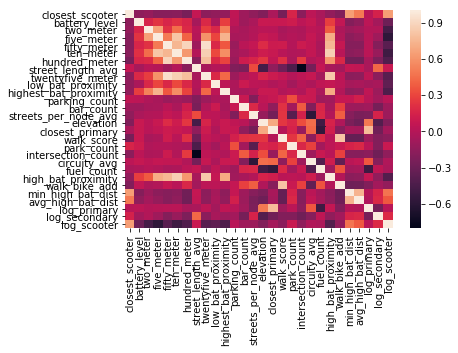

In [121]:
#explore correlations between features and to the Nest Dummy

feature_matrix = data[significant_features]

# calculate correlation matrix
corr = feature_matrix.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Additional Visualizations

Text(0.5,1,'Log of Closest Scooter in Meters vs Walk Score \n with Nest Classification by color')

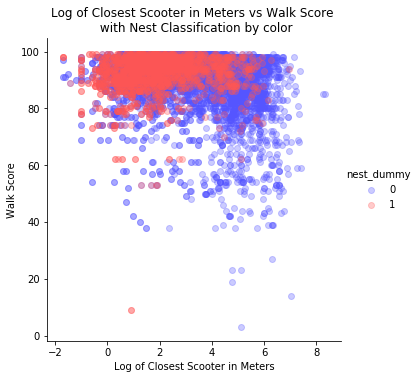

In [122]:
sns.lmplot(x = 'log_scooter', y = 'walk_score', 
           data = data, 
           hue = "nest_dummy", 
           palette="seismic", 
           scatter_kws={'alpha':0.3},
           fit_reg = False)
plt.xlabel('Log of Closest Scooter in Meters')
plt.ylabel('Walk Score')
plt.title('Log of Closest Scooter in Meters vs Walk Score \n with Nest Classification by color')

Text(0.5,1,'Log of Closest Scooter in Meters vs Log of Closest Highway in Meters \n with Nest Classification by color')

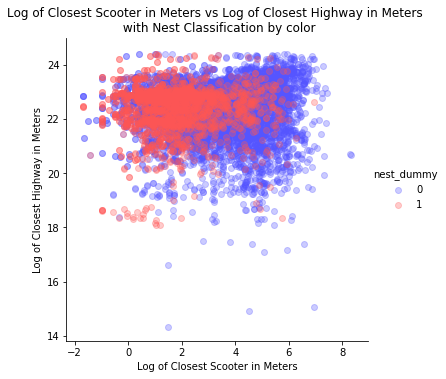

In [123]:
sns.lmplot(x = 'log_scooter', y = 'log_highway', 
           data = data, 
           hue = "nest_dummy", 
           palette="seismic", 
           scatter_kws={'alpha':0.3},
           fit_reg = False)
plt.xlabel('Log of Closest Scooter in Meters')
plt.ylabel('Log of Closest Highway in Meters')
plt.title('Log of Closest Scooter in Meters vs Log of Closest Highway in Meters \n with Nest Classification by color')

Text(0.5,1,'Log of Closest Scooter in Meters vs Battery Level \n with Nest Classification by color')

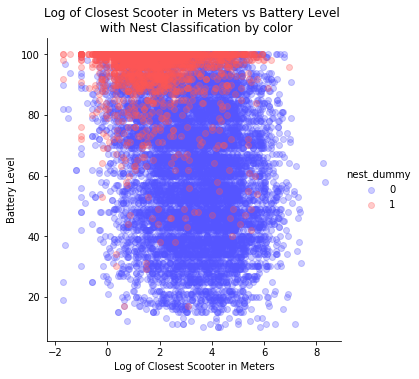

In [124]:
sns.lmplot(x = 'log_scooter', y = 'battery_level', 
           data = data, 
           hue = "nest_dummy", 
           palette="seismic", 
           scatter_kws={'alpha':0.3},
           fit_reg = False)
plt.xlabel('Log of Closest Scooter in Meters')
plt.ylabel('Battery Level')
plt.title('Log of Closest Scooter in Meters vs Battery Level \n with Nest Classification by color')

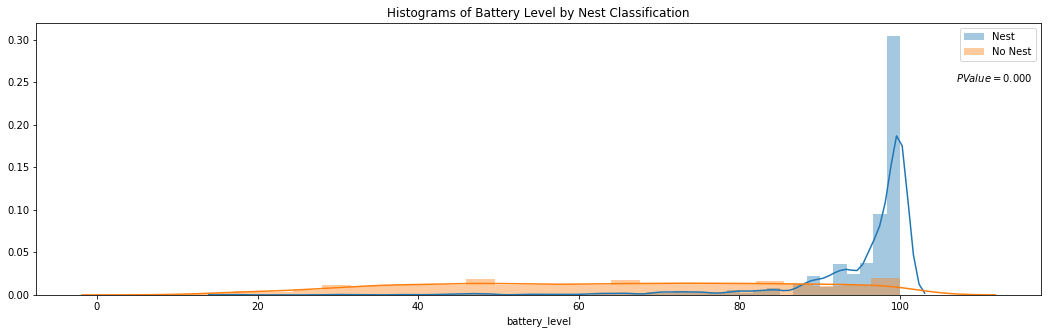

In [125]:
fig, (ax15) = plt.subplots(1, 1, figsize=(18, 5))

nest = data['battery_level'][data['nest_dummy'] == 1]
no_nest = data['battery_level'][data['nest_dummy'] == 0]

sns.distplot(nest, label='Nest')
sns.distplot(no_nest, label='No Nest')


plt.title('Histograms of Battery Level by Nest Classification')
plt.text(107, 0.25, r'$PValue =0.000$')
plt.legend()

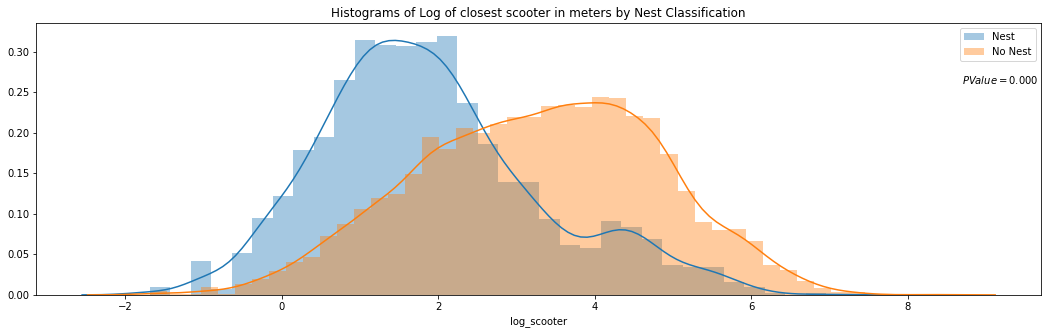

In [126]:
fig, (ax15) = plt.subplots(1, 1, figsize=(18, 5))

nest = data['log_scooter'][data['nest_dummy'] == 1]
no_nest = data['log_scooter'][data['nest_dummy'] == 0]

sns.distplot(nest, label='Nest')
sns.distplot(no_nest, label='No Nest')

plt.title('Histograms of Log of closest scooter in meters by Nest Classification')
plt.text(8.7, 0.26, r'$PValue =0.000$')
plt.legend() 

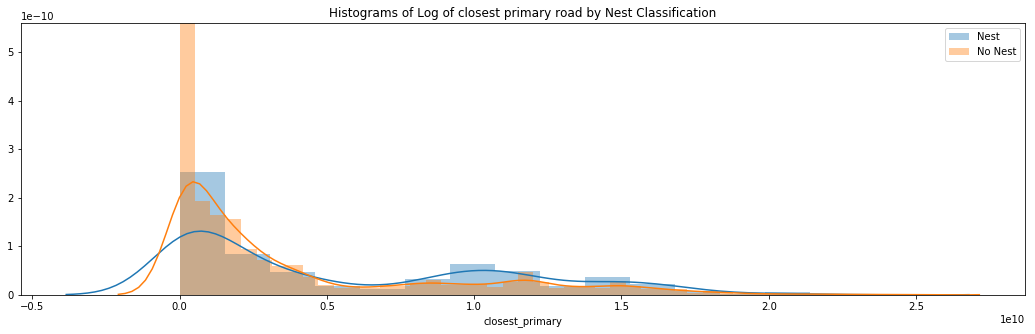

In [127]:
fig, (ax15) = plt.subplots(1, 1, figsize=(18, 5))

nest = data['closest_primary'][data['nest_dummy'] == 1]
no_nest = data['closest_primary'][data['nest_dummy'] == 0]

sns.distplot(nest, label='Nest')
sns.distplot(no_nest, label='No Nest')


plt.title('Histograms of Log of closest primary road by Nest Classification')
plt.legend()

# Model Development

In [128]:
print(significant_features)

['closest_scooter', 'battery_level', 'two_meter', 'five_meter', 'fifty_meter', 'ten_meter', 'hundred_meter', 'street_length_avg', 'twentyfive_meter', 'low_bat_proximity', 'highest_bat_proximity', 'parking_count', 'bar_count', 'streets_per_node_avg', 'elevation', 'closest_primary', 'walk_score', 'park_count', 'intersection_count', 'circuity_avg', 'fuel_count', 'high_bat_proximity', 'walk_bike_add', 'min_high_bat_dist', 'avg_high_bat_dist', 'log_primary', 'log_secondary', 'log_scooter']


In [129]:
# Use the relevant features

X = data[significant_features]

y = data['nest_dummy']

#split into training set and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

In [130]:
#create test metrics and results ouput function

def test_results(model, Xtest, ytest):
    
    y_pred = model.predict(Xtest)
    y_pred_proba = model.predict_proba(Xtest)[:,1]

    #Confusion matrix
    CM = confusion_matrix(ytest, y_pred)
    print ("\n\nConfusion matrix:\n", CM)    

    #True Positive, True Negative, False Positive, False Negative from Confusion Matrix
    tn, fp, fn, tp = CM.ravel()
    print ("\nTP, TN, FP, FN:", tp, ",", tn, ",", fp, ",", fn)


    #Accuracy rate
    AR = accuracy_score(ytest, y_pred)
    print ("\nAccuracy rate:", np.round(AR, 3))

    #Error rate
    ER = 1.0 - AR
    print ("\nError rate:", np.round(ER, 3))

    #Precision: True Positive / (True Positive + False Positive)
    P = precision_score(ytest, y_pred)
    print ("\nPrecision:", np.round(P, 3))

    #Recall:true Positive / (Trupe Positive + False Negative)
    R = recall_score(ytest, y_pred)
    print ("\nRecall:", np.round(R, 3))

    #F1 Score
    F1 = f1_score(ytest, y_pred)
    print ("\nF1 score:", np.round(F1, 3))


    # ROC Curve and AUC Analysis
    LW = 1.5 # line width for plots
    LL = "lower right" # legend location
    LC = 'darkgreen' # Line Color

    # False Positive Rate, True Posisive Rate, probability thresholds
    fpr, tpr, th = roc_curve(ytest, y_pred_proba) 
    AUC = auc(fpr, tpr)
    #print ("\nTP rates:", np.round(tpr, 2))
    #print ("\nFP rates:", np.round(fpr, 2))
    #print ("\nProbability thresholds:", np.round(th, 2))


    plt.figure()
    plt.title('Receiver Operating Characteristic curve example')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FALSE Positive Rate')
    plt.ylabel('TRUE Positive Rate')
    plt.plot(fpr, tpr, color=LC,lw=LW, label='ROC curve (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--') 
    plt.legend(loc=LL)
    plt.show()

    print ("\nAUC score (using auc function):", np.round(AUC, 3))
    print ("\nAUC score (using roc_auc_score function):", np.round(roc_auc_score(ytest, y_pred_proba), 3), "\n")

# XGB Classifier Model

In [131]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'eval_metric': ['auc'],
    'max_depth': [2, 4, 6, 8, 10],
    'n_estimators': [100, 500, 750, 1000]
}



# Create a based model
xgb = XGBClassifier()


# Instantiate the grid search model
xgb_grid_search = RandomizedSearchCV(estimator = xgb, param_distributions= param_grid, 
                         cv = 5, n_jobs = -1)

# fit the model
xgb_grid_search.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1], 'eval_metric': ['auc'], 'max_depth': [2, 4, 6, 8, 10], 'n_estimators': [100, 500, 750, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [132]:
#Best estimator and CV score
print('Best Accuracy score ', xgb_grid_search.best_score_)
print(xgb_grid_search.best_estimator_)

xgb_model = xgb_grid_search.best_estimator_

Best Accuracy score  0.9167340339531124
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.3,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)




Confusion matrix:
 [[2417  112]
 [ 150  503]]

TP, TN, FP, FN: 503 , 2417 , 112 , 150

Accuracy rate: 0.918

Error rate: 0.082

Precision: 0.818

Recall: 0.77

F1 score: 0.793


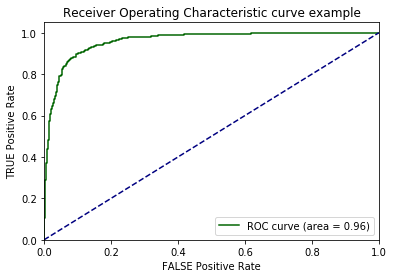


AUC score (using auc function): 0.959

AUC score (using roc_auc_score function): 0.959 



In [133]:
test_results(xgb_model, Xtest, ytest)

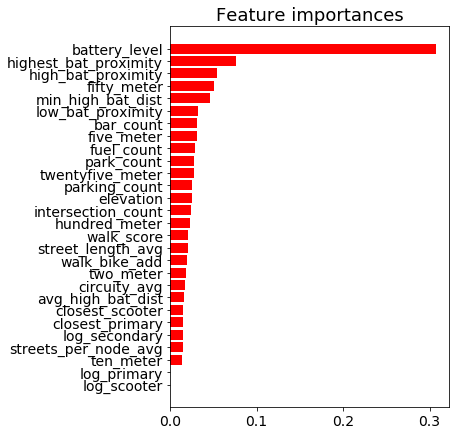

In [134]:
features = X.columns
feature_importance = xgb_model.feature_importances_
indices = np.argsort(feature_importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], feature_importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14)

# Random Forest Classifier Model

In [135]:
# Number of trees in random forest
n_estimators = [300, 400, 500, 600, 700, 800]
# Number of features to consider at every split
max_features = [2, 3, 4, 5, 6, 7]
# Maximum number of levels in tree
max_depth = [20, 22, 24]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
              'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


#Random Search Training for hyperparamters
rf = RandomForestClassifier()

rfc_grid_search = RandomizedSearchCV(estimator = rf, param_distributions= random_grid, 
                                 cv = 5, n_jobs = -1)

rfc_grid_search.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [300, 400, 500, 600, 700, 800], 'max_features': [2, 3, 4, 5, 6, 7], 'max_depth': [20, 22, 24], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [136]:
#Best estimator and CV score
print('Best Accuracy score ', rfc_grid_search.best_score_)
print(rfc_grid_search.best_estimator_)

rfc_model = rfc_grid_search.best_estimator_

Best Accuracy score  0.9143088116410671
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=24, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)




Confusion matrix:
 [[2425  104]
 [ 170  483]]

TP, TN, FP, FN: 483 , 2425 , 104 , 170

Accuracy rate: 0.914

Error rate: 0.086

Precision: 0.823

Recall: 0.74

F1 score: 0.779


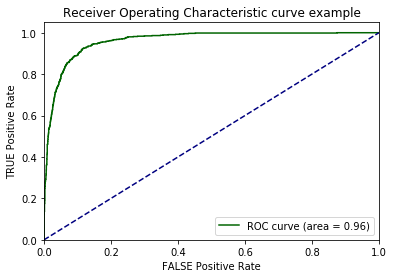


AUC score (using auc function): 0.961

AUC score (using roc_auc_score function): 0.961 



In [137]:
test_results(rfc_model, Xtest, ytest)

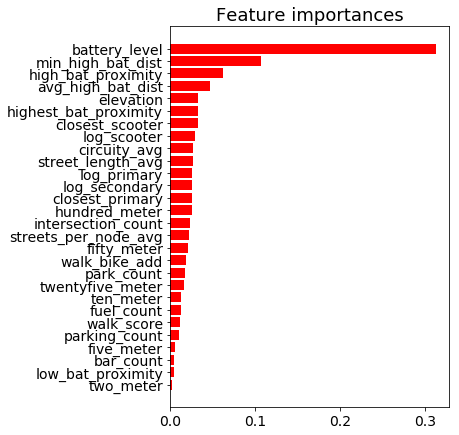

In [138]:
features = X.columns
feature_importance = rfc_model.feature_importances_
indices = np.argsort(feature_importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], feature_importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14)

# Testing Nest Classification Models on 3 New Cities (Columbus, Fort Lauderdale, San Diego) That Were Not Used In Training

In [139]:
test_data = pd.read_csv('final_test.csv', index_col=0)

In [140]:
test_data.shape

(629, 58)

In [141]:
# create additional features 
test_data['log_highway'] = np.log(test_data['closest_highway'])
test_data['log_scooter'] = np.log(test_data['closest_scooter'])
test_data['log_primary'] = np.log(test_data['closest_primary'])
test_data['log_residential'] = np.log(test_data['closest_residential'])
test_data['log_secondary'] = np.log(test_data['closest_secondary'])
test_data['walk_bike_dynamic'] = test_data['walk_score'] * test_data['bike_score']
test_data['walk_bike_add'] = test_data['walk_score'] + test_data['bike_score']

In [142]:
X_test = test_data[significant_features]

y_test = test_data['nest_dummy']



Confusion matrix:
 [[486  16]
 [ 42  85]]

TP, TN, FP, FN: 85 , 486 , 16 , 42

Accuracy rate: 0.908

Error rate: 0.092

Precision: 0.842

Recall: 0.669

F1 score: 0.746


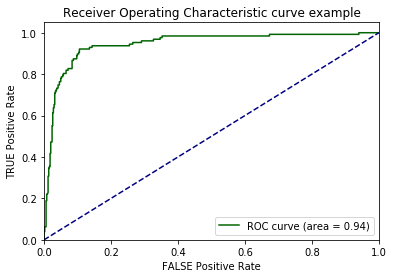


AUC score (using auc function): 0.945

AUC score (using roc_auc_score function): 0.945 



In [143]:
# test XGB Model on completely new cities
test_results(xgb_model, X_test, y_test)



Confusion matrix:
 [[488  14]
 [ 40  87]]

TP, TN, FP, FN: 87 , 488 , 14 , 40

Accuracy rate: 0.914

Error rate: 0.086

Precision: 0.861

Recall: 0.685

F1 score: 0.763


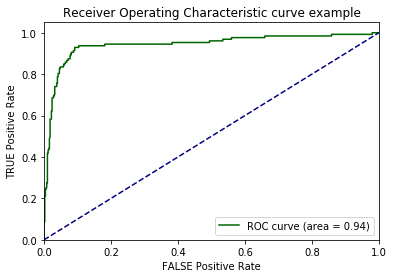


AUC score (using auc function): 0.943

AUC score (using roc_auc_score function): 0.943 



In [144]:
# test Random Forest Classifier Model on completely new cities
test_results(rfc_model, X_test, y_test)

# Back to the Drawing Board for Run-Time Compliant Model

In [145]:
# features generated directly from the Bird API
features = ['log_scooter', 'battery_level', 'two_meter', 'five_meter', 'fifty_meter', 'ten_meter', 'hundred_meter',
    'twentyfive_meter', 'low_bat_proximity', 'highest_bat_proximity', 'min_high_bat_dist', 'avg_high_bat_dist', 'closest_scooter']

In [146]:
significant_features = []
not_significant = []
for i in features:
    nest = data[i][data['nest_dummy'] == 1]
    no_nest = data[i][data['nest_dummy'] == 0]
    test = t_test(nest, no_nest, 0.001)
    if test[3] <= 0.001:
        significant_features.append(i)
    else:
        not_significant.append(i)
print(significant_features)    

['log_scooter', 'battery_level', 'two_meter', 'five_meter', 'fifty_meter', 'ten_meter', 'hundred_meter', 'twentyfive_meter', 'low_bat_proximity', 'highest_bat_proximity', 'min_high_bat_dist', 'avg_high_bat_dist', 'closest_scooter']


In [147]:
len(significant_features)

13

In [148]:
len(not_significant)

0

In [149]:
# Use the relevant features

X = data[significant_features]

y = data['nest_dummy']

#split into training set and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

In [150]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'eval_metric': ['auc'],
    'max_depth': [2, 4, 6, 8, 10],
    'n_estimators': [100, 500, 750, 1000]
}



# Create a based model
xgb = XGBClassifier()


# Instantiate the grid search model
xgb_grid_search = RandomizedSearchCV(estimator = xgb, param_distributions= param_grid, 
                         cv = 5, n_jobs = -1)

# fit the model
xgb_grid_search.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1], 'eval_metric': ['auc'], 'max_depth': [2, 4, 6, 8, 10], 'n_estimators': [100, 500, 750, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [151]:
#Best estimator and CV score
print('Best Accuracy score ', xgb_grid_search.best_score_)
print(xgb_grid_search.best_estimator_)

xgb_model = xgb_grid_search.best_estimator_

Best Accuracy score  0.900296416060361
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.01,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


In [152]:
# Number of trees in random forest
n_estimators = [300, 400, 500, 600, 700, 800, 900]
# Number of features to consider at every split
max_features = [2, 3, 4, 5, 6, 7]
# Maximum number of levels in tree
max_depth = [20, 21, 22, 23, 24]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
              'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


#Random Search Training for hyperparamters
rf = RandomForestClassifier()

rfc_grid_search = RandomizedSearchCV(estimator = rf, param_distributions= random_grid, 
                                 cv = 5, n_jobs = -1)

rfc_grid_search.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [300, 400, 500, 600, 700, 800, 900], 'max_features': [2, 3, 4, 5, 6, 7], 'max_depth': [20, 21, 22, 23, 24], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [153]:
#Best estimator and CV score
print('Best Accuracy score ', rfc_grid_search.best_score_)
print(rfc_grid_search.best_estimator_)

rfc_model = rfc_grid_search.best_estimator_

Best Accuracy score  0.9017784963621666
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=22, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [154]:
X_test = test_data[significant_features]

y_test = test_data['nest_dummy']



Confusion matrix:
 [[484  18]
 [ 34  93]]

TP, TN, FP, FN: 93 , 484 , 18 , 34

Accuracy rate: 0.917

Error rate: 0.083

Precision: 0.838

Recall: 0.732

F1 score: 0.782


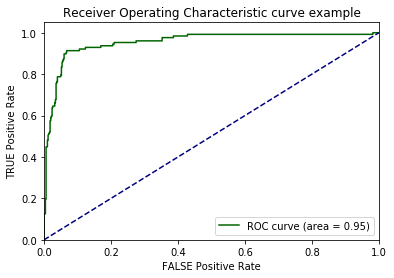


AUC score (using auc function): 0.954

AUC score (using roc_auc_score function): 0.954 



In [155]:
# test XGB Model on completely new cities
test_results(xgb_model, X_test, y_test)



Confusion matrix:
 [[486  16]
 [ 39  88]]

TP, TN, FP, FN: 88 , 486 , 16 , 39

Accuracy rate: 0.913

Error rate: 0.087

Precision: 0.846

Recall: 0.693

F1 score: 0.762


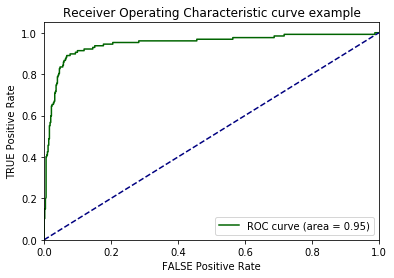


AUC score (using auc function): 0.947

AUC score (using roc_auc_score function): 0.947 



In [156]:
# test Random Forest Classifier Model on completely new cities
test_results(rfc_model, X_test, y_test)